In [1]:
# 1 . CARGAR LA LIBRERIAS NECESARIAS PARA EL MODELO

In [ ]:
# IMPORTAR LIBRERIAS
%reset -f
import sys
import numpy as np
import pandas as pd
from ipywidgets import interact_manual, Layout
import ipywidgets as widgets

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

widgets.interact_manual.opts['manual_name'] = "Run!"
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [ ]:
# 2. MODELO MATEMATICO SOCIAL

In [40]:
# MODELO SOCIAL
class MS_CienagaRioLaVieja():
    def __init__(self, init_year, end_year):
        self.init_year = init_year
        self.end_year = end_year
        self.dictionary()
        
    def __call__(self,
                Pas_ini_ha,
                Cul_tra_ini_ha, Cul_per_ini_ha, Cul_het_ini_ha,
                Caf_ini_ha,
                Gan_ini_cb,
                Pob_ini_ru,
                Pob_ini_cb):
        
        self.res = self.model(Pas_ini_ha, 
                              Cul_tra_ini_ha, Cul_per_ini_ha, Cul_het_ini_ha,\
                              Caf_ini_ha, Gan_ini_cb, Pob_ini_ru, Pob_ini_cb)
        self.modelExtr()
    
    # RUN
    def model(self,
             Pas_ini_ha,
             Cul_tra_ini_ha, Cul_per_ini_ha, Cul_het_ini_ha,
             Caf_ini_ha,
             Gan_ini_cb,
             Pob_ini_ru,
             Pob_ini_cb):
        
        # Assig values
        
        Pc_cul  = self.dict['Habitantes requeridos por ha de cultivos']
        Pc_caf  = self.dict['Habitantes requeridos por ha de cultivo de cafe']
        Pg_cab  = self.dict['Habitantes requeridos por cabeza de ganado']
        tur_HaC = self.dict['Turistas atraidos por cada ha de cafe']
        P_tur   = self.dict['Habitantes requeridos por el sector turistico']
        Ps_P    = self.dict['Habitantes requeridos por el sector servicios']
        Pru_IDR = self.dict['Migracion rural atraida']
        Pcb_IDU = self.dict['Migracion cabecera atraida']
        
        T_CulTr   = self.dict['Tasa de cambio del cultivo - Transitorio']
        Tend_AreaCulTr = self.dict['Area tendencial del cultivo - Transitorio']
        T_CulPr   = self.dict['Tasa de cambio del cultivo - Permanente']
        Tend_AreaCulPr = self.dict['Area tendencial del cultivo - Permanente']
        T_CulHt   = self.dict['Tasa de cambio del cultivo - Heterogeneo']
        Tend_AreaCulHt = self.dict['Area tendencial del cultivo - Heterogeneo']
        
        T_cafe = self.dict['Tasa de cambio del cultivo de cafe']
        Tend_AreaCaf = self.dict['Area tendencial del cultivo de cafe']
        
        Soporte = self.dict['Ganado soportado por una ha de pasto']
        T_crec  = self.dict['Tasa de crecimiento natural del ganado bovino']
        T_sacrif = self.dict['Tasa de sacrificio del ganado bovino']
        Requerimie = self.dict['Ha de pasto requerido por el ganado']
        
        T_cnat_rul = self.dict['Tasa de crecimiento natural - Población rural']
        T_cnat_cab = self.dict['Tasa de crecimiento natural - Población cabecera']
        
        # Run model
        Cul_ini_ha = Cul_tra_ini_ha + Cul_per_ini_ha + Cul_het_ini_ha
        
        ano = [self.init_year]
        Pas_lts = [Pas_ini_ha]
        
        Ctr_lts = [Cul_tra_ini_ha]
        Cpr_lts = [Cul_per_ini_ha]
        Cht_lts = [Cul_het_ini_ha]
        
        Cul_lts = [Cul_ini_ha]
        Caf_lts = [Caf_ini_ha]
        Gan_lts = [Gan_ini_cb]
        
        Pru_lts = [Pob_ini_ru]
        Pca_lts = [Pob_ini_cb]
        
        tur_lts = [tur_HaC * Caf_ini_ha]
        PDES_lts   = [np.nan]
        
        for year in np.arange(self.init_year + 1 , self.end_year + 1):
            
            # JOIN ECO to POB
            
            Pcul = int(Pc_cul * Cul_ini_ha)
            Pcaf = int(Pc_caf * Caf_ini_ha)
            Pgan = int(Pg_cab * Gan_ini_cb)
            tur  = int(tur_HaC * Caf_ini_ha)
            Ptur = int(P_tur * tur)
            Pser = int(Ps_P * Pob_ini_cb)
            
            try:
                PDR = (Pcul + Pcaf + Pgan + Ptur) / Pob_ini_ru
            except:
                PDR = 0
            
            try:
                PDU = Pser / Pob_ini_cb
            except:
                PDU = 0
            
            try:
                PDES_lts.append((Pob_ini_ru + Pob_ini_cb - Pcul - Pcaf - Pgan - Ptur - Pser) / (Pob_ini_ru + Pob_ini_cb))
            except:
                PDES_lts.append(1)
                
            ME_ru = Pru_IDR * PDR
            ME_cb = Pcb_IDU * PDU
            
            # 4.1. Area de cultivo
            Cul_tra = self.RK4(init=Cul_tra_ini_ha, h=1, fs=[T_CulTr/4, Tend_AreaCulTr], fun=self.dAc_dt)
            Cul_tra = 0 if Cul_tra <= 0 else Cul_tra
            
            Cul_per = self.RK4(init=Cul_per_ini_ha, h=1, fs=[T_CulPr/4, Tend_AreaCulPr], fun=self.dAc_dt)
            Cul_per = 0 if Cul_per <= 0 else Cul_per
            
            Cul_het = self.RK4(init=Cul_het_ini_ha, h=1, fs=[T_CulHt/4, Tend_AreaCulHt], fun=self.dAc_dt)
            Cul_het = 0 if Cul_het <= 0 else Cul_het
            
            Cul = Cul_tra + Cul_per + Cul_het
            
            # 4.2. Area de cultivo de cafe
            Caf = self.RK4(init=Caf_ini_ha, h=1, fs=[T_cafe/4, Tend_AreaCaf], fun=self.dAcafe_dt)
            Caf = 0 if Caf <= 0 else Caf
            
            # JOIN A to G
            Soport = Pas_ini_ha * Soporte
            
            # 4.3. Ganaderia values
            G = self.RK4(Gan_ini_cb, h=1, fs=[T_crec/4, T_sacrif/4, Soport], fun=self.dG_dt)
            G = 0 if G <= 0 else int(G)
            
            # JOIN G to A
            T_pas = Requerimie * ((G - Gan_ini_cb)/G) if G !=0 else 0
            
            # 4.4 Area values
            A = self.RK4(Pas_ini_ha, h=1, fs=[T_pas / 4], fun=self.dA_dt)
            A = 0 if A <= 0 else A
            
            # 4.5. Poblacion Rural
            P_rul = self.RK4(init=Pob_ini_ru, h=1, fs=[T_cnat_rul/4., ME_ru], fun=self.dPob_dt)
            P_rul = 0 if P_rul <= 0 else int(P_rul)
            
            # 4.6. Poblacion cabecera
            P_cab = self.RK4(init=Pob_ini_cb, h=1, fs=[T_cnat_cab/4., ME_cb], fun=self.dPob_dt)
            P_cab = 0 if P_cab <= 0 else int(P_cab)
    
            # 5. Add result to list
            Pas_lts.append(A)
            Gan_lts.append(G)
            
            Ctr_lts.append(Cul_tra)
            Cpr_lts.append(Cul_per)
            Cht_lts.append(Cul_het)
            Cul_lts.append(Cul)
            
            Caf_lts.append(Caf)
            Pru_lts.append(P_rul)
            Pca_lts.append(P_cab)
            tur_lts.append(tur)
            
            ano.append(year)
            
            # 6. Actualizar valores
            
            Cul_tra_ini_ha = Cul_tra
            Cul_per_ini_ha = Cul_per
            Cul_het_ini_ha = Cul_het
            Cul_ini_ha = Cul_tra_ini_ha + Cul_per_ini_ha + Cul_het_ini_ha
            Caf_ini_ha = Caf
            Gan_ini_cb = G
            Pas_ini_ha = A
            
            Pob_ini_ru = P_rul
            Pob_ini_cb = P_cab
            
        # 7. ADD RESULTS
        res = pd.DataFrame()
        res['Ano'] = ano
        
        res['Area Cultivo - Transitorio'] = Ctr_lts
        res['Area Cultivo - Permanente']  = Cpr_lts
        res['Area Cultivo - Heterogeneo'] = Cht_lts
        res['Area Cultivo']    = Cul_lts
        
        res['Area Cult. cafe'] = Caf_lts
        res['Area Pasto']      = Pas_lts
        res['Ganado']          = Gan_lts
        
        res['Pob. rural']      = Pru_lts
        res['Pob. cabecera']   = Pca_lts
        res['Pob. Turistas']   = tur_lts
        
        res['Tasa de desempeleo'] = PDES_lts
        
        # 8. RESET INDEX
        res.index = res['Ano']
        res.drop('Ano', axis=1, inplace=True)
        
        return(res)
    
    def modelExtr(self):
        
        # VARIABLES
        T_sac   = self.dict['Tasa de sacrificio del ganado bovino']
        kg_cab  = self.dict['Peso en canal por cabeza de ganado']
        COP_kg  = self.dict['Precio por kilogramo de carne en canal']
        ton_haC = self.dict['Rendimiento agricola']
        cop_kgC = self.dict['Precio de venta de la produccion agricola']
        ton_haCafe = self.dict['Rendimiento del cultivo de cafe']
        cop_kgcafe = self.dict['Precio del kilogramo cafe']
        DotNetaHab = self.dict['Dotacion neta promedio']
        PorcPerd = self.dict['Porcentqaje de perdidad']
        DotNetaBov = self.dict['Consumo de agua ganadero']
        
        # ADD CHARACTERISTICS
        self.res['Poblacion total'] = self.res['Pob. rural'] + self.res['Pob. cabecera']
        
        self.res['Ganado sacrificado'] = self.res['Ganado'] * T_sac
        self.res['Capital ganadero']    = self.res['Ganado sacrificado'] * kg_cab * COP_kg
        
        self.res['Produccion agricola'] = self.res['Area Cultivo'] * ton_haC
        self.res['Capital agricola'] = self.res['Produccion agricola'] * 1000 * cop_kgC
        
        self.res['Produccion de cafe'] = self.res['Area Cult. cafe'] * ton_haCafe
        self.res['Capital cafetero '] = self.res['Produccion de cafe'] * 1000 * cop_kgcafe
        
        self.res['Demanda de agua - uso domestico'] = (self.res['Poblacion total'] + self.res['Pob. Turistas']) * DotNetaHab * (1/86_400.) * (1 + PorcPerd)
        self.res['Demanda de agua - uso pecuario'] = self.res['Ganado'] * DotNetaBov * (1/86_400.)
        
        self.res['Demanda de agua - uso agricola - Cultivo Transitorio'] = self.DemAguaAgri(self.res['Area Cultivo - Transitorio'], coef_type = 'trn')
        self.res['Demanda de agua - uso agricola - Cultivo Permanente']  = self.DemAguaAgri(self.res['Area Cultivo - Permanente'], coef_type = 'per')
        self.res['Demanda de agua - uso agricola - Cultivo Heterogeneo'] = self.DemAguaAgri(self.res['Area Cultivo - Heterogeneo'], coef_type = 'htr')
        
        self.res['Demanda de agua - uso agricola'] = self.res['Demanda de agua - uso agricola - Cultivo Transitorio'] +\
            self.res['Demanda de agua - uso agricola - Cultivo Permanente'] + self.res['Demanda de agua - uso agricola - Cultivo Heterogeneo']
        
        self.res['Demanda de agua - uso agricola - cafetero'] = self.DemAguaAgri(self.res['Area Cult. cafe'], coef_type = 'cafe!')
        
        self.res['Demanda total de agua'] = self.res['Demanda de agua - uso domestico'] + self.res['Demanda de agua - uso pecuario'] +\
                                            self.res['Demanda de agua - uso agricola'] + self.res['Demanda de agua - uso agricola - cafetero']
        
        return(None)
    
    # MODELOS
    @staticmethod
    def dAcafe_dt(Acafe_ini, fs):
        return(Acafe_ini * fs[0] * (1 - Acafe_ini / fs[1]))
    
    @staticmethod
    def dAc_dt(A_ini, fs):
        return(A_ini * fs[0] * (1 - A_ini / fs[1]))
    
    @staticmethod
    def dA_dt(A_ini, fs):
        return(A_ini * fs[0])
    
    @staticmethod
    def dG_dt(G_ini, fs):
        return(G_ini*(fs[0] - fs[1])*(1 - G_ini/fs[2]))
    
    @staticmethod
    def dPob_dt(Pob_ini, fs):
        return(Pob_ini * fs[0] + fs[1])
    
    # Otros
    def DemAguaAgri(self, area_lts, coef_type):
        
        # 1. extraer valores por defecto
        umbralescorrentia = 25.020896     
        prec = np.array(self.dict['Precipitacion media mensual multianual'])
        evap = np.array(self.dict['Evapotranspiracion media mensual multianual'])
        
        # 2. extraer valores dependientes del calculo
        if coef_type == 'per':
            coef = np.array(self.dict['Coeficiente mensual de cultivos - Permanente'])
        elif coef_type == 'trn':
            coef = np.array(self.dict['Coeficiente mensual de cultivos - Transitorio'])
        elif coef_type == 'htr':
            coef = np.array(self.dict['Coeficiente mensual de cultivos - Heterogeneo'])
        elif coef_type == 'cafe!':
            coef = np.array(self.dict['Coeficiente mensual de cultivos - Cafe'])
        else:
            sys.exit('coef_type invalid!. Valids = [per, trn, htr, cafe!]')
        
        area = np.array(list(area_lts))
        area = np.expand_dims(area, axis=0)
        
        # 3. Calculo de la demanda por area
        prec_neta = ((prec - umbralescorrentia) ** 2) / ((prec + 4 * umbralescorrentia))
        demanda = (evap * coef - prec_neta) * (10_000/(31*86400))
        demanda[prec_neta > evap] = 0
        demanda = np.expand_dims(demanda, axis=0)
        
        # 4. Calcular la demanda de agua
        DemandaCalc = area.T * demanda
        DemandaCalc = np.max(DemandaCalc, axis=1)
        return(list(DemandaCalc))
    
    @staticmethod
    def RK4(init, h, fs, fun):
        subStep = 4
        h_int = h / subStep
        for ii in list(range(subStep)):
            k1 = fun(init          , fs)
            k2 = fun(init + k1 / 2., fs)
            k3 = fun(init + k2 / 2., fs)
            k4 = fun(init + k3     , fs)
            m = h_int * (k1 + 2 * k2 + 2 * k3 + k4) / 6.
            init = init + m
        return(init)

    def dictionary(self):
        self.dict = {
            # PARAMETROS CALIBRADOS
            'Tasa de crecimiento natural - Población rural' :0.4523786507420768,
            'Tasa de crecimiento natural - Población cabecera' :0.046158964648240236,
            
            'Habitantes requeridos por cabeza de ganado' : 0.03170731707317073,
            'Habitantes requeridos por ha de cultivos': 0.2567813901893124,
            'Habitantes requeridos por ha de cultivo de cafe': 1.1717936636226582,
            'Habitantes requeridos por el sector servicios': 0.6164363774925519,
            'Habitantes requeridos por el sector turistico': 3.1387512963254247,
            
            'Migracion rural atraida': -4073.705495428765,
            'Migracion cabecera atraida': -3156.063317267045,
            
            'Tasa de cambio del cultivo - Transitorio': 0.450155114,
            'Area tendencial del cultivo - Transitorio': 4917.606257,
            
            'Tasa de cambio del cultivo - Permanente': 1,
            'Area tendencial del cultivo - Permanente': 21365.7061,
            
            'Tasa de cambio del cultivo - Heterogeneo': 0.049495313,
            'Area tendencial del cultivo - Heterogeneo': 8691.083895,
            
            'Tasa de cambio del cultivo': 0.029019536330867172,
            'Area tendencial del cultivo': 20_000.0,
            
            'Tasa de cambio del cultivo de cafe': 0.5,
            'Area tendencial del cultivo de cafe': 28213.886641980112,
            
            'Tasa de crecimiento natural del ganado bovino': 0.8513797086002215,
            'Tasa de sacrificio del ganado bovino': 0.45,
            'Ha de pasto requerido por el ganado': 1.122484651827749,
            'Ganado soportado por una ha de pasto': 2,

            'Turistas atraidos por cada ha de cafe': 2.01651863734517,
            
            # PARAMENTRO EXTRA
            'Peso en canal por cabeza de ganado' : 245.08,
            'Precio por kilogramo de carne en canal' : 10_500,
            
            'Rendimiento agricola': 8.6019, # ton/ha
            'Precio de venta de la produccion agricola': 650, #cop/kg
            
            'Rendimiento del cultivo de cafe': 6.1, #ton/ha
            'Precio del kilogramo cafe': 15_500, # cop/kg
            
            'Dotacion neta promedio':95,# L/Hab/dia
            'Porcentqaje de perdidad': 0.17, # %
            
            'Consumo de agua ganadero': 86.40,# l/dia/cabeza
            
            'Precipitacion media mensual multianual':[128.50,
                                                      100.70,
                                                      243.06,
                                                      241.23,
                                                      265.54,
                                                      113.43,
                                                      42.89,
                                                      30.59,
                                                      176.01,
                                                      374.25,
                                                      222.00,
                                                      234.90],
            
            'Evapotranspiracion media mensual multianual':[109.56,
                                                           98.96,
                                                           110.80,
                                                           106.90,
                                                           110.03,
                                                           106.21,
                                                           109.12,
                                                           109.83,
                                                           105.93,
                                                           108.80,
                                                           104.90,
                                                           108.60],
            
            'Coeficiente mensual de cultivos - Permanente':[1.00, 1.00, 1.50,\
                                                            1.50, 1.50, 1.10,\
                                                            1.00, 1.00, 1.50,\
                                                            1.50, 1.50, 1.10],
            'Coeficiente mensual de cultivos - Transitorio':[1.20, 1.10, 1.20,\
                                                             1.20, 1.20, 1.20,\
                                                             1.20, 1.10, 1.20,\
                                                             1.20, 1.20, 1.20],
            'Coeficiente mensual de cultivos - Heterogeneo':[1.20, 1.10, 1.20,\
                                                             1.20, 1.20, 1.20,\
                                                             1.20, 1.10, 1.20,\
                                                             1.20, 1.20, 1.20],
            'Coeficiente mensual de cultivos - Cafe':[0.90, 0.90, 0.95,\
                                                      0.95, 0.95, 0.95,\
                                                      0.90, 0.90, 0.95,\
                                                      0.95, 0.95, 0.95],
            }
        return(None)
    
    def example(self):
        self.init_year = 2014
        self.end_year = 2050

        Pas_ini_ha = 70_163.1
        Cul_tra_ini_ha = 3_295.490896
        Cul_per_ini_ha = 18_525.14429
        Cul_het_ini_ha = 38_156.24065
        Caf_ini_ha = 31_001.4
        Gan_ini_cb = 113_781
        
        Pob_ini_ru = 93_964
        Pob_ini_cb = 672_154
        
        self.res = self.model(Pas_ini_ha, 
                              Cul_tra_ini_ha, Cul_per_ini_ha, Cul_het_ini_ha,
                              Caf_ini_ha, Gan_ini_cb, Pob_ini_ru, Pob_ini_cb)
        self.modelExtr()

## MODELO SOCIAL - CUENCA RÍO LA VIEJA

En este notebook se presenta el modelo social generado a partir de dinamica de sistemas para el comportamiento de las principales variables de la cuenca del Río la Vieja. Este se basa en las relaciones causales identificadas pare el sector de estudio, las cuales se observan en el diagrama de forrester presentado a continuación.

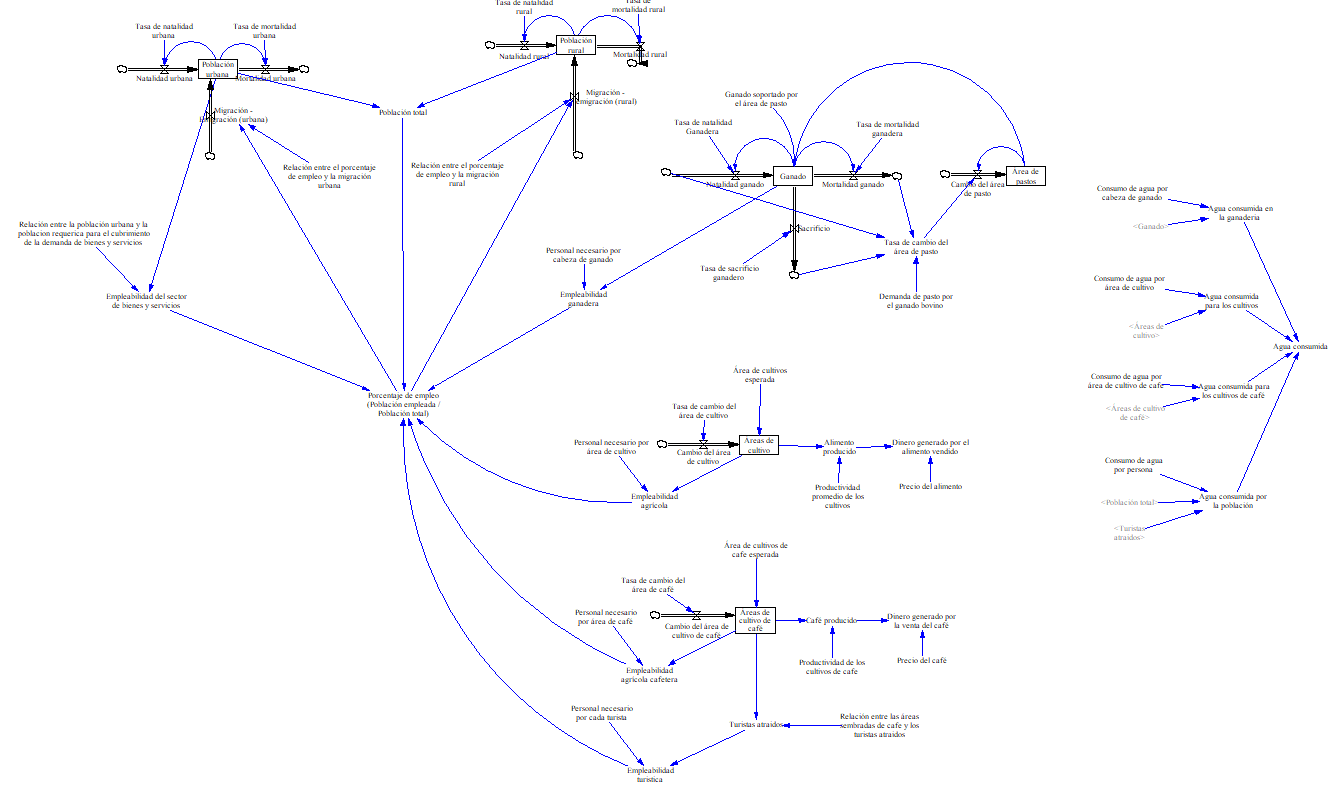

*Autoria propia*

In [41]:
# RUN MODEL
def run(p0, p1, p2, p3, p4, p5,
        p6, p7, p8, p9, p10,p11,
        e0, e1, e2, e3, e4, e5,
        e6, e7, e8, e9, e10,e11,
        g0, g1, g2, g3, 
        g4, g5, g6, g7):
    
    months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo','Junio',
          'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    
    # RUN SIMULATED VALUES

    model = MS_CienagaRioLaVieja(init_year= 0, end_year = 1)
    model.example()
    res0 = model.res.copy()
    
    Psim = model.dict['Precipitacion media mensual multianual']
    Esim = model.dict['Evapotranspiracion media mensual multianual']
    del(model)

    ##############################################################
    ##############################################################
    # INICIO DE "PIECE OF CODE"
    # AQUI SE PODRAN CAMBIAR OTROS PARAMETROS PARA CORRER ALGUN 
    # ESCENARIO EN PARTICULAR
    ##############################################################
    ##############################################################
    
    model = MS_CienagaRioLaVieja(init_year= 2018, end_year = 2050)

    # RUN SCENARY VALUES 
    Pas_ini_ha = 71_453.4
    Cul_tra_ini_ha = 3_735.497386
    Cul_per_ini_ha = 20_140.88839
    Cul_het_ini_ha = 32_934.18232
    Caf_ini_ha = 29_887.3
    Gan_ini_cb = 121_466
    Pob_ini_ru = 92_797
    Pob_ini_cb = 696_046
    
    model.dict['Precipitacion media mensual multianual']=[p0, p1, p2, p3, p4, p5,\
                                                          p6, p7, p8, p9, p10,p11]
    
    model.dict['Evapotranspiracion media mensual multianual']=[e0, e1, e2, e3, e4, e5,\
                                                               e6, e7, e8, e9, e10,e11]
    
    model.dict['Area tendencial del cultivo de cafe'] = g0
    model.dict['Area tendencial del cultivo - Transitorio'] = g1
    model.dict['Area tendencial del cultivo - Permanente'] = g2
    model.dict['Area tendencial del cultivo - Heterogeneo'] = g3
    
    model.dict['Rendimiento del cultivo de cafe'] = g4
    model.dict['Rendimiento agricola'] = g5
    
    model.dict['Precio del kilogramo cafe'] = g6
    model.dict['Precio de venta de la produccion agricola'] = g7

    model(Pas_ini_ha, 
          Cul_tra_ini_ha, Cul_per_ini_ha, Cul_het_ini_ha, Caf_ini_ha,
          Gan_ini_cb, Pob_ini_ru, Pob_ini_cb)

    res1 = model.res.copy()
    
    Pese = model.dict['Precipitacion media mensual multianual']
    Eese = model.dict['Evapotranspiracion media mensual multianual']
    del(model)
    ##############################################################
    ##############################################################
    # FIN DE "PIECE OF CODE"
    ##############################################################
    ##############################################################

    # BUILD GRAPH
    
    ################################# CLIMA ######################################################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))
    
    fig.add_trace(go.Bar(x=months, y=Psim,
                            name='Precipitacion'), 1, 1)
    fig.add_trace(go.Bar(x=months, y=Esim,
                            name='Evapotranspiracion'), 1, 1)
    
    fig.add_trace(go.Bar(x=months, y=Pese,
                            name='Precipitacion'), 1, 2)
    fig.add_trace(go.Bar(x=months, y=Eese,
                            name='Evapotranspiracion'), 1, 2)
    
    fig.show()

    ################################# AREA ######################################################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Cultivo - Transitorio'], mode='lines',
                            name='Area Cultivo - Transitorio', line=dict(color='#b22222', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Cultivo - Permanente'],  mode='lines',
                            name='Area Cultivo - Permanente', line=dict(color='#22b2b2', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Cultivo - Heterogeneo'], mode='lines',
                            name='Area Cultivo - Heterogeneo', line=dict(color='#b2226a', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Cult. cafe'],            mode='lines',
                            name='Area Cult. cafe', line=dict(color='#b26a22', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Cultivo'],               mode='lines',
                            name='Area Cultivo', line=dict(color='#226ab2', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Area Pasto'],               mode='lines',
                            name='Area Pasto', line=dict(color='#2222b2', width=4)), 1, 1)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Cultivo - Transitorio'], mode='lines',
                            name='Area Cultivo - Transitorio', line=dict(color='#b22222', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Cultivo - Permanente'],  mode='lines',
                            name='Area Cultivo - Permanente', line=dict(color='#22b2b2', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Cultivo - Heterogeneo'], mode='lines',
                            name='Area Cultivo - Heterogeneo', line=dict(color='#b2226a', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Cult. cafe'],            mode='lines',
                            name='Area Cult. cafe', line=dict(color='#b26a22', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Cultivo'],               mode='lines',
                            name='Area Cultivo', line=dict(color='#226ab2', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Area Pasto'],               mode='lines',
                            name='Area Pasto', line=dict(color='#2222b2', width=4)), 1, 2)

    fig.update_layout(title='Cambio del área en el tiempo',
                       xaxis_title='Fecha', yaxis_title='ha')
    fig.show()
    ################################## POBLACION ##################################################

    fig = make_subplots(rows=2, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Pob. rural'], mode='lines',
                            name='Pob. rural', line=dict(color='#b22222', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Pob. cabecera'],  mode='lines',
                            name='Pob. cabecera', line=dict(color='#22b2b2', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Pob. Turistas'], mode='lines',
                            name='Pob. Turistas', line=dict(color='#b2226a', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Poblacion total'],            mode='lines',
                            name='Poblacion total', line=dict(color='#b26a22', width=4)), 1, 1)

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Tasa de desempeleo'],               mode='lines',
                            name='Tasa de desempeleo', line=dict(color='#2222b2', width=4)), 2, 1)


    fig.add_trace(go.Scatter(x=res1.index, y=res1['Pob. rural'], mode='lines',
                            name='Pob. rural', line=dict(color='#b22222', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Pob. cabecera'],  mode='lines',
                            name='Pob. cabecera', line=dict(color='#22b2b2', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Pob. Turistas'], mode='lines',
                            name='Pob. Turistas', line=dict(color='#b2226a', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Poblacion total'],            mode='lines',
                            name='Poblacion total', line=dict(color='#b26a22', width=4)), 1, 2)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Tasa de desempeleo'],               mode='lines',
                            name='Tasa de desempeleo', line=dict(color='#2222b2', width=4)), 2, 2)

    fig.update_layout(title='Cambio de la población en el tiempo',
                       xaxis_title='Fecha', yaxis_title='hab')
    fig.show()
    ############################### SERVICIOS ECOSISTEMICOS ##################################

    fig = make_subplots(rows=2, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Ganado'], mode='lines',
                            name='Ganado', line=dict(color='#b22222', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Ganado sacrificado'],  mode='lines',
                            name='Ganado sacrificado', line=dict(color='#22b2b2', width=4)), 1, 1)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Ganado'], mode='lines',
                            name='Ganado', line=dict(color='#b22222', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Ganado sacrificado'],  mode='lines',
                            name='Ganado sacrificado', line=dict(color='#22b2b2', width=4)), 1, 2)

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Produccion agricola'], mode='lines',
                            name='Produccion agricola', line=dict(color='#b2226a', width=4)), 2, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Produccion de cafe'],            mode='lines',
                            name='Produccion de cafe', line=dict(color='#b26a22', width=4)), 2, 1)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Produccion agricola'], mode='lines',
                            name='Produccion agricola', line=dict(color='#b2226a', width=4)), 2, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Produccion de cafe'],            mode='lines',
                            name='Produccion de cafe', line=dict(color='#b26a22', width=4)), 2, 2)

    fig.update_layout(title='Cambio del servicio ecosistemico en el tiempo',
                       xaxis_title='Fecha')
    fig.show()
    ################################ CAPITAL ECONOMICO #####################################

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Capital agricola'], mode='lines',
                            name='Capital agricola', line=dict(color='#b22222', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Capital cafetero '],  mode='lines',
                            name='Capital cafetero ', line=dict(color='#22b2b2', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Capital ganadero'], mode='lines',
                            name='Capital ganadero', line=dict(color='#2222b2', width=4)), 1, 1)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Capital agricola'], mode='lines',
                            name='Capital agricola', line=dict(color='#b22222', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Capital cafetero '],  mode='lines',
                            name='Capital cafetero ', line=dict(color='#22b2b2', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Capital ganadero'], mode='lines',
                            name='Capital ganadero', line=dict(color='#2222b2', width=4)), 1, 2)

    fig.update_layout(title='Cambio del capital economico en el tiempo',
                       xaxis_title='Fecha', yaxis_title='COP')

    fig.show()
    ############################### DEMANDA DE AGUA #####################################
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                       subplot_titles=("Resultados simulados", "Resultados escenario"))

    fig.add_trace(go.Scatter(x=res0.index, y=res0['Demanda de agua - uso domestico'], mode='lines',
                            name='Demanda de agua - uso domestico', line=dict(color='#b22222', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Demanda de agua - uso pecuario'],  mode='lines',
                            name='Demanda de agua - uso pecuario', line=dict(color='#22b2b2', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Demanda de agua - uso agricola'], mode='lines',
                            name='Demanda de agua - uso agricola', line=dict(color='#b2226a', width=4)), 1, 1)
    fig.add_trace(go.Scatter(x=res0.index, y=res0['Demanda de agua - uso agricola - cafetero'],            mode='lines',
                            name='Demanda de agua - uso agricola - cafetero', line=dict(color='#b26a22', width=4)), 1, 1)

    fig.add_trace(go.Scatter(x=res1.index, y=res1['Demanda de agua - uso domestico'], mode='lines',
                            name='Demanda de agua - uso domestico', line=dict(color='#b22222', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Demanda de agua - uso pecuario'],  mode='lines',
                            name='Demanda de agua - uso pecuario', line=dict(color='#22b2b2', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Demanda de agua - uso agricola'], mode='lines',
                            name='Demanda de agua - uso agricola', line=dict(color='#b2226a', width=4)), 1, 2)
    fig.add_trace(go.Scatter(x=res1.index, y=res1['Demanda de agua - uso agricola - cafetero'],            mode='lines',
                            name='Demanda de agua - uso agricola - cafetero', line=dict(color='#b26a22', width=4)), 1, 2)

    fig.update_layout(title='Cambio de la demanda de agua en el tiempo',
                       xaxis_title='Fecha', yaxis_title='l/s')
    fig.show()

    tmp1 = res0.copy()
    tmp1.reset_index(drop=False, inplace=True)
    tmp1 = tmp1[['Demanda total de agua', 'Ano']].copy()

    tmp2 = res1.copy()
    tmp2.reset_index(drop=False, inplace=True)
    tmp2 = tmp2[['Demanda total de agua', 'Ano']].copy()

    DemTot = pd.merge(tmp1, tmp2, how='outer', on='Ano', suffixes=(" Simulado", " Escenario"))
    DemTot['Diferencia'] = abs(DemTot['Demanda total de agua Simulado'] - DemTot['Demanda total de agua Escenario'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=DemTot['Ano'], y=DemTot['Demanda total de agua Simulado'], mode='lines',
                            name='Demanda total de agua - Simulada', line=dict(color='#b22222', width=4)))
    fig.add_trace(go.Scatter(x=DemTot['Ano'], y=DemTot['Demanda total de agua Escenario'],  mode='lines',
                            name='Demanda total de agua - Escenario', line=dict(color='#22b2b2', width=4)))
    fig.add_trace(go.Scatter(x=DemTot['Ano'], y=DemTot['Diferencia'], mode='lines',
                            name='Demanda total de agua - Diferencia', line=dict(color='#b2226a', width=4)))

    fig.update_layout(title='Cambio de la demanda total de agua en el tiempo',
                       xaxis_title='Fecha', yaxis_title='l/s')
    fig.show()

    return(None)

In [ ]:
# CARGAR VALORES POR DEFECTO PARA EL MODELO

In [44]:
# SELECTOR VALUES
DESCRIBE  = ['Área cult. cafe final - Ha',
             'Área cult. transitorio final - Ha',
             'Área cult. permanente final - Ha',
             'Área cult. heterogeneo final - Ha',
             'Rendimiento promedio del cultivo de cafe - Ton/Ha/año',
             'Rendimiento promedio agricola - Ton/Ha/año',
             'Precio del kilogramo cafe - COP/kg',
             'Precio de venta de la produccion agricola - COP/kg']
init_vals = [28213.886641980112,
             4917.606257,
             21365.7061,
             8691.083895,
             8.6019,
             6.1,
             15_500,
             650]
months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo','Junio',
          'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
mensualPrec = [128.50, 100.70, 243.06, 241.23,
               265.54, 113.43, 42.89, 30.59,
               176.01, 374.25, 222.00, 234.90]
mensualEvap = [109.56, 98.96, 110.80, 106.90,
               110.03, 106.21, 109.12, 109.83,
               105.93, 108.80, 104.90, 108.60]
tab_contents = ['Precipitacion', 'Evapotranspiracion']

A continuación, se presentan los resultados obtenidos por medio de la calibración del modelo con los datos observados, denominado *Resultados simulados* y los resultados obtenidos a partir del cambio de los parámetros mostrados *Resultados escenario*. Los resultados por defecto mostrados como *Resultados escenario*, corresponden a los mismos parámetros usados para obtener los *Resultados simulados*.

Para correr el escenario con los nuevos parámetros es necesario precionar el boton "Run!". 

*Para cambiar otro parámetro se debe hacer a partir del código, en el sector denominado "piece of code"*

In [45]:
# BUILD APP
itemsG = [widgets.FloatText(description=val[0], value=val[1], style={'description_width': 'initial'}, layout=Layout(width='60%')) for val in zip(DESCRIBE, init_vals)]

itemsP = [widgets.FloatText(description=tab_contents[0] + ' - ' + val[0] + ' - '+r'\(mm/m^2\)', value=val[1], style={'description_width': 'initial'}, layout=Layout(width='60%')) for val in zip(months, mensualPrec)]
itemsE = [widgets.FloatText(description=tab_contents[1] + ' - ' + val[0] + ' - '+r'\(mm/m^2\)', value=val[1], style={'description_width': 'initial'}, layout=Layout(width='60%')) for val in zip(months, mensualEvap)]

print('----------------------- PARAMETROS ------------------------')
widgets.interact_manual(run, 
                 p0=itemsP[0], p1=itemsP[1], p2=itemsP[2],  p3 =itemsP[3],
                 p4=itemsP[4], p5=itemsP[5], p6=itemsP[6],  p7 =itemsP[7],
                 p8=itemsP[8], p9=itemsP[9], p10=itemsP[10],p11=itemsP[11],
                 e0=itemsE[0], e1=itemsE[1], e2=itemsE[2], e3=itemsE[3],
                 e4=itemsE[4], e5=itemsE[5], e6=itemsE[6], e7=itemsE[7],
                 e8=itemsE[8], e9=itemsE[9], e10=itemsE[10],e11=itemsE[11],
                 g0=itemsG[0], g1=itemsG[1], g2=itemsG[2], g3=itemsG[3], 
                 g4=itemsG[4], g5=itemsG[5], g6=itemsG[6], g7=itemsG[7])

----------------------- PARAMETROS ------------------------


interactive(children=(FloatText(value=128.5, description='Precipitacion - Enero - \\(mm/m^2\\)', layout=Layout…

<function __main__.run(p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, e0, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, g0, g1, g2, g3, g4, g5, g6, g7)>